In [1]:
from transformers.pipelines import SUPPORTED_TASKS

In [2]:
SUPPORTED_TASKS

{'audio-classification': {'impl': transformers.pipelines.audio_classification.AudioClassificationPipeline,
  'tf': (),
  'pt': (transformers.models.auto.modeling_auto.AutoModelForAudioClassification,),
  'default': {'model': {'pt': ('superb/wav2vec2-base-superb-ks', '372e048')}},
  'type': 'audio'},
 'automatic-speech-recognition': {'impl': transformers.pipelines.automatic_speech_recognition.AutomaticSpeechRecognitionPipeline,
  'tf': (),
  'pt': (transformers.models.auto.modeling_auto.AutoModelForCTC,
   transformers.models.auto.modeling_auto.AutoModelForSpeechSeq2Seq),
  'default': {'model': {'pt': ('facebook/wav2vec2-base-960h', '22aad52')}},
  'type': 'multimodal'},
 'text-to-audio': {'impl': transformers.pipelines.text_to_audio.TextToAudioPipeline,
  'tf': (),
  'pt': (transformers.models.auto.modeling_auto.AutoModelForTextToWaveform,
   transformers.models.auto.modeling_auto.AutoModelForTextToSpectrogram),
  'default': {'model': {'pt': ('suno/bark-small', '1dbd7a1')}},
  'type': 

In [3]:
from transformers import pipeline

In [4]:
pipe = pipeline(task="text-classification", model="uer/roberta-base-finetuned-dianping-chinese")

Device set to use mps:0


In [5]:
pipe('我觉得不太行')

[{'label': 'negative (stars 1, 2 and 3)', 'score': 0.9743660688400269}]

# Preload model and tokenizer

In [6]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

In [7]:
model = AutoModelForSequenceClassification.from_pretrained("uer/roberta-base-finetuned-dianping-chinese")
tokenizer = AutoTokenizer.from_pretrained("uer/roberta-base-finetuned-dianping-chinese")
pipe = pipeline(task="text-classification", model=model, tokenizer=tokenizer)

Device set to use mps:0


In [8]:
pipe('我觉得不太行')

[{'label': 'negative (stars 1, 2 and 3)', 'score': 0.9743660688400269}]

In [9]:
pipe.model.device

device(type='mps', index=0)

# Find arguments of pipeline

In [10]:
qa_pipe = pipeline(task="question-answering", model='uer/roberta-base-chinese-extractive-qa')

Device set to use mps:0


In [11]:
qa_pipe

In [12]:
qa_pipe(
    question='中国的首都是哪里？',
    context='北京是中华人民共和国的首都，位于华北平原的北部，地处东经115°25′至117°30′、北纬39°26′至41°03′之间。'
)

{'score': 0.23128585517406464, 'start': 0, 'end': 2, 'answer': '北京'}

# Other pipelines

In [13]:
checkpoint = 'google/owlvit-base-patch32'
detector = pipeline(task="zero-shot-object-detection", model=checkpoint)
detector

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use mps:0


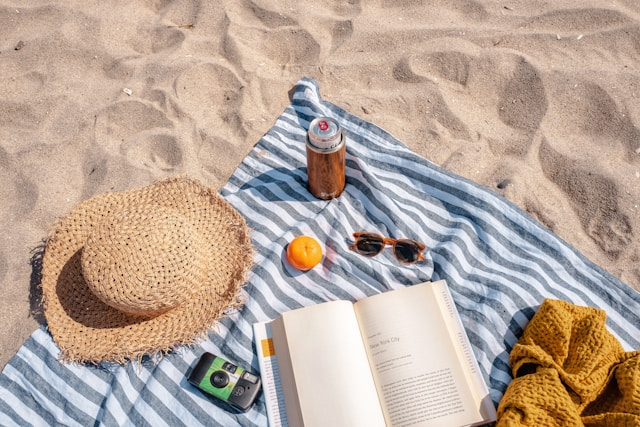

In [14]:
import requests
from PIL import Image

url = "https://unsplash.com/photos/oj0zeY2Ltk4/download?ixid=MnwxMjA3fDB8MXxzZWFyY2h8MTR8fHBpY25pY3xlbnwwfHx8fDE2Nzc0OTE1NDk&force=true&w=640"
image = Image.open(requests.get(url, stream=True).raw)
image

In [15]:
predictions = detector(image, candidate_labels=["hat", "sunglasses", "book"])
predictions

[{'score': 0.2589304745197296,
  'label': 'sunglasses',
  'box': {'xmin': 349, 'ymin': 228, 'xmax': 430, 'ymax': 265}},
 {'score': 0.18501627445220947,
  'label': 'book',
  'box': {'xmin': 270, 'ymin': 284, 'xmax': 502, 'ymax': 427}},
 {'score': 0.11234723031520844,
  'label': 'hat',
  'box': {'xmin': 39, 'ymin': 173, 'xmax': 260, 'ymax': 363}}]

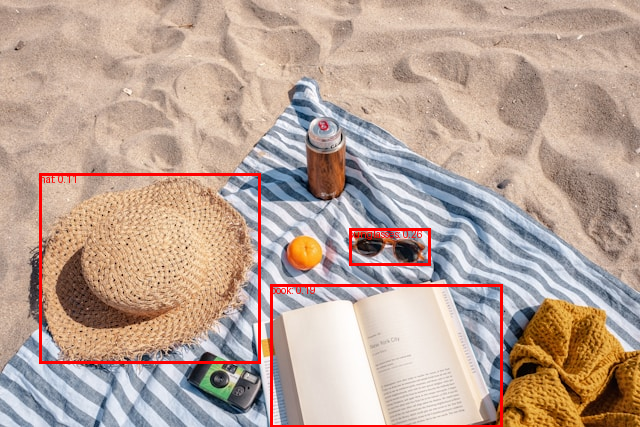

In [16]:
from PIL import ImageDraw
draw = ImageDraw.Draw(image)
for prediction in predictions:
    box = prediction['box']
    label = prediction['label']
    score = prediction['score']
    xmin, ymin, xmax, ymax = box.values()
    draw.rectangle(
        [xmin, ymin, xmax, ymax],
        outline='red', width=3
    )
    draw.text((xmin, ymin), f"{label}: {round(score, 2)}", fill='red')
image

# Impletation of a pipeline

In [17]:
import torch

In [18]:
tokenizer = AutoTokenizer.from_pretrained("uer/roberta-base-finetuned-dianping-chinese")
model = AutoModelForSequenceClassification.from_pretrained("uer/roberta-base-finetuned-dianping-chinese")

In [19]:
input_text = "我觉得不太行"
inputs = tokenizer(input_text, return_tensors="pt")
inputs

{'input_ids': tensor([[ 101, 2769, 6230, 2533,  679, 1922, 6121,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}

In [20]:
results = model(**inputs)
results

SequenceClassifierOutput(loss=None, logits=tensor([[ 1.7459, -1.8919]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [21]:
logits = results.logits
logits = torch.softmax(logits, dim=1)
logits

tensor([[0.9744, 0.0256]], grad_fn=<SoftmaxBackward0>)

In [22]:
pred = torch.argmax(logits).item()
pred

0

In [23]:
model.config.id2label

{0: 'negative (stars 1, 2 and 3)', 1: 'positive (stars 4 and 5)'}

In [24]:
result = model.config.id2label.get(pred)
result

'negative (stars 1, 2 and 3)'